## Dataset

In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
class EEGDataset(Dataset):
    # Define a mapping from class labels to integers as a class attribute
    class_mapping = {'cat': 0, 'dog': 1, 'rabbit': 2, 'control': 3}

    def __init__(self, json_file, SEGMENT_LENGTH=123):
        with open(json_file, 'r') as file:
            data = json.load(file)

        self.data = []
        for subject in data['subjects']:
            for image in subject['view_images']:
                image_class = image['class']

                # Exclude samples with class 'no_stimuli'
                if image_class == 'no_stimuli':
                    continue

                # Map the class label to an integer
                class_int = self.class_mapping.get(image_class, -1)  # Default to -1 for unknown classes

                eeg_signal = image['EEG_signal']
                # Segment the EEG signal
                for i in range(0, len(eeg_signal), SEGMENT_LENGTH):
                    segment = eeg_signal[i:i + SEGMENT_LENGTH]
                    if len(segment) == SEGMENT_LENGTH:
                        self.data.append({
                            "subject": subject['name'],
                            "EEG_signal": segment,
                            "class": class_int,  # Use the integer label
                            "age": subject['age'],
                            "sex": subject['sex'],
                            "has_cat": subject['has_cat'],
                            "has_dog": subject['has_dog'],
                            "has_rabbit": subject['has_rabbit']
                        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        eeg_signal = torch.tensor(item['EEG_signal'], dtype=torch.float)
        return {
            "eeg_signal": eeg_signal,
            "class": item['class'],
            "subject": item['subject'],
            "age": item['age'],
            "sex": item['sex'],
            "has_cat": item['has_cat'],
            "has_dog": item['has_dog'],
            "has_rabbit": item['has_rabbit']
        }

# Access class_mapping
# print(EEGDataset.class_mapping)


In [3]:
# Dataset object
eeg_dataset = EEGDataset('SynapSee_data.json')


In [6]:
print("Class mapping:", eeg_dataset.class_mapping)
print("Number of samples:", len(eeg_dataset))
print("Sample keys:", eeg_dataset[0].keys())
print("Sample signal shape:", eeg_dataset[0]['eeg_signal'].shape)
eeg_dataset[0]

Class mapping: {'cat': 0, 'dog': 1, 'rabbit': 2, 'control': 3}
Number of samples: 4729
Sample keys: dict_keys(['eeg_signal', 'class', 'subject', 'age', 'sex', 'has_cat', 'has_dog', 'has_rabbit'])
Sample signal shape: torch.Size([123, 16])


{'eeg_signal': tensor([[ 60780.4727,   9003.2158, -19887.7773,  ..., -38451.0820,
           -3099.1140, -34363.0117],
         [ 60772.3828,   9008.8262, -19882.9727,  ..., -38440.1289,
           -3101.8411, -34357.3125],
         [ 60769.4766,   9000.1533, -19889.0293,  ..., -38432.7305,
           -3090.0168, -34359.3711],
         ...,
         [ 60713.1953,   9093.6953, -19860.8438,  ..., -38357.6055,
           -3114.9167, -34372.0000],
         [ 60706.0859,   9085.2021, -19861.6699,  ..., -38351.2344,
           -3103.6738, -34365.5820],
         [ 60706.1992,   9089.7168, -19861.0898,  ..., -38351.2344,
           -3108.4795, -34365.9844]]),
 'class': 0,
 'subject': 'dani',
 'age': 22,
 'sex': 1,
 'has_cat': False,
 'has_dog': True,
 'has_rabbit': False}

In [7]:
from sklearn.model_selection import train_test_split

# Assume 'labels' is a list of labels for stratification (e.g., classes of EEG data)
labels = [item['class'] for item in eeg_dataset.data]

# Split the indices of your dataset
train_indices, val_indices = train_test_split(
    range(len(eeg_dataset)),
    test_size=0.2,  # 20% for validation
    stratify=labels,
    random_state=420  # For reproducibility
)

# Creating subsets for training and validation
train_subset = torch.utils.data.Subset(eeg_dataset, train_indices)
val_subset = torch.utils.data.Subset(eeg_dataset, val_indices)



In [8]:
train_subset[0]


{'eeg_signal': tensor([[ 23128.1543,  14883.5801, -53514.9922,  ..., -58291.4062,
          -33851.9180, -54510.7852],
         [ 23104.7520,  14880.2715, -53523.5547,  ..., -58365.1641,
          -33897.5820, -54539.2617],
         [ 23052.0469,  14823.1406, -53593.6719,  ..., -58346.2344,
          -33885.0664, -54539.9102],
         ...,
         [ 22315.1543,  14145.4355, -54425.6484,  ..., -59367.5078,
          -34564.7617, -55369.2734],
         [ 22316.3398,  14131.9131, -54444.9609,  ..., -59332.7734,
          -34487.5117, -55339.3438],
         [ 22292.5352,  14124.3359, -54450.0352,  ..., -59392.6758,
          -34560.0664, -55375.3516]]),
 'class': 1,
 'subject': 'pato',
 'age': 22,
 'sex': 1,
 'has_cat': True,
 'has_dog': True,
 'has_rabbit': False}

Training set class counts: {1: 948, 2: 946, 0: 949, 3: 940}
Validation set class counts: {0: 237, 3: 235, 1: 237, 2: 237}
Training set class percentages:
1: 25.1%
2: 25.0%
0: 25.1%
3: 24.8%
Validation set class percentages:
0: 25.1%
3: 24.8%
1: 25.1%
2: 25.1%


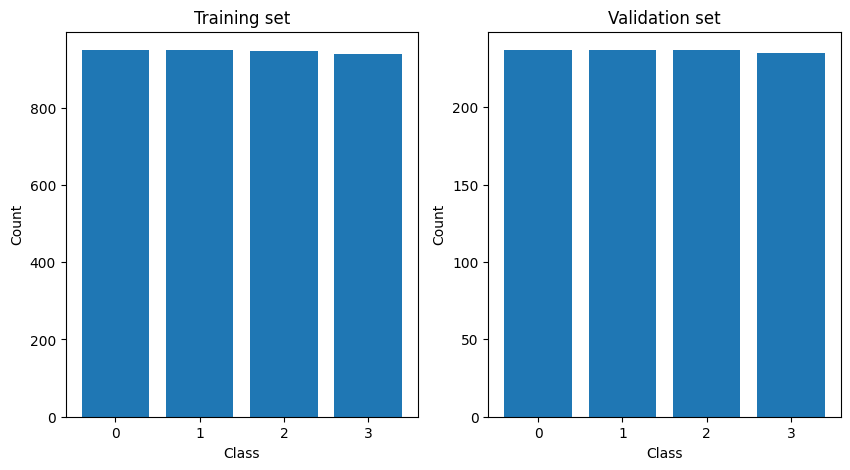

In [9]:
def count_classes(dataset):
    """ Count the occurrences of each class in the dataset. """
    class_counts = {}
    for item in dataset:
        label = item['class']
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

# Count classes in each subset
train_class_counts = count_classes(train_subset)
val_class_counts = count_classes(val_subset)

# print counts
print("Training set class counts:", train_class_counts)
print("Validation set class counts:", val_class_counts)

# print percentages
print("Training set class percentages:")
for label, count in train_class_counts.items():
    print(f"{label}: {count / len(train_subset):.1%}")
print("Validation set class percentages:")
for label, count in val_class_counts.items():
    print(f"{label}: {count / len(val_subset):.1%}")


# Plot the class distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Training set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.bar(val_class_counts.keys(), val_class_counts.values())
plt.title('Validation set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()



## DataLoader

In [10]:
batch_size = 10

In [11]:
# DataLoader object
data_loader = DataLoader(eeg_dataset, batch_size=batch_size, shuffle=True)

# DataLoader object for training
for batch in data_loader:
    # Extrae los datos de cada batch
    eeg_signals = batch['eeg_signal']  # This will be a tensor
    classes = batch['class']  
    print("EEG signal shape:", eeg_signals.shape)
    print("Classes:", classes, len(classes))
    break


EEG signal shape: torch.Size([10, 123, 16])
Classes: tensor([2, 3, 2, 2, 2, 1, 0, 1, 3, 1]) 10


In [12]:
# Explore the DataLoader object
print("Number of batches in DataLoader:", len(data_loader))
print("Batch size:", data_loader.batch_size)


Number of batches in DataLoader: 473
Batch size: 10


In [13]:
# Fetch the first batch
one_batch = next(iter(data_loader))

# Print the type and structure of the batch
print("Type of the batch:", type(one_batch))
print("Keys in the batch:", one_batch.keys())

# Print the shape of each item in the batch
for key in one_batch.keys():
    try:
        print(f"Shape of {key}:", one_batch[key].shape)
    except AttributeError:
        # In case it's not a tensor and doesn't have a shape attribute
        print(f"{key} contains:", one_batch[key])


Type of the batch: <class 'dict'>
Keys in the batch: dict_keys(['eeg_signal', 'class', 'subject', 'age', 'sex', 'has_cat', 'has_dog', 'has_rabbit'])
Shape of eeg_signal: torch.Size([10, 123, 16])
Shape of class: torch.Size([10])
subject contains: ['pato', 'mateo', 'pato', 'pato', 'pato', 'pato', 'mateo', 'pato', 'muri', 'pato']
Shape of age: torch.Size([10])
Shape of sex: torch.Size([10])
Shape of has_cat: torch.Size([10])
Shape of has_dog: torch.Size([10])
Shape of has_rabbit: torch.Size([10])


In [14]:
del data_loader, one_batch

In [15]:
# Create DataLoaders for training and validation sets
# train loader is shuffled to avoid overfitting
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
# validation loader is not shuffled cause is used for evaluation
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGConv(nn.Module):
    def __init__(self, num_classes=4):
        super(EEGConv, self).__init__()
        
        input_channels = 16  # Adjust this if the number of channels is different
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3)

        # Assume some flattening and reduction happen after convolution
        # The number 123 - 2 is based on the convolution operation without padding
        conv_output_size = (123 - 2) * 64  

        # First fully connected layer
        self.fc1 = nn.Linear(conv_output_size, 128)  # 128 is an example size

        # Second fully connected layer
        self.fc2 = nn.Linear(128, 64)  # 64 is an example size

        # Final classifier layer
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):

        # N is the batch size
        # C is the number of channels
        # L is the length of the signal sequence

        # EEG signal shape: torch.Size([10, 123, 16])
        # N: 10 is the batch size
        # L: 123 is the length of the signal sequence
        # C: 16 is the number of channels

        # Since we need to match the input to (N, C, L) format expected by nn.Conv1d,
        # we need to transpose the input
        x = x.transpose(1, 2)  # Transpose the 2nd and 3rd dimension

        # Apply the first convolutional layer
        x = F.relu(self.conv1(x))

        # Flatten the output for the fully connected layers
        # x.view() is similar to numpy.reshape()
        # The -1 is a placeholder for an inferred dimension
        x = x.view(x.size(0), -1)

        # Apply the first fully connected layer
        x = F.relu(self.fc1(x))

        # Apply the second fully connected layer
        x = F.relu(self.fc2(x))

        # Apply the classifier
        x = self.classifier(x)

        return x

# Example usage
# model = EEGNet(num_classes=4)
# output = model(eeg_signal)  # eeg_signal should be a batch from your DataLoader


In [17]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = EEGConv(num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (example: using Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


Device: cuda


In [18]:
num_epochs = 1000  # Number of epochs, adjust as needed

# Lists to keep track of training progress
train_losses = []
val_losses = []
val_accuracies = []

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    total_train_loss = 0

    for batch in train_loader:
        # Get data to cuda if possible
        eeg_signals = batch['eeg_signal'].to(device)
        targets = batch['class'].to(device)

        # Forward pass
        outputs = model(eeg_signals)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct = 0
    total = 0

    # We don't need to track gradients during validation
    with torch.no_grad():
        for batch in val_loader:
            eeg_signals = batch['eeg_signal'].to(device)
            targets = batch['class'].to(device)

            # Forward pass
            outputs = model(eeg_signals)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            # To calculate accuracy
            # torch.max returns the maximum value and its index
            # Since the index is what we want, we can ignore the maximum value
            # basically, we are extracting the predicted class index for each sample
            # index because the index is equal to the class
            _, predicted = torch.max(outputs.data, 1)
            # total number of samples
            total += targets.size(0)
            # total correct predictions
            correct += (predicted == targets).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / total

    # Save losses and accuracy to plot later
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Check if early stopping is needed
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break
    
    # Print statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    


Epoch [1/1000], Train Loss: 244.6216, Validation Loss: 5.0608, Validation Accuracy: 0.2706
Epoch [2/1000], Train Loss: 2.0307, Validation Loss: 1.5038, Validation Accuracy: 0.2696
Epoch [3/1000], Train Loss: 1.4488, Validation Loss: 1.3441, Validation Accuracy: 0.2791
Epoch [4/1000], Train Loss: 1.3671, Validation Loss: 1.3574, Validation Accuracy: 0.2643
Epoch [5/1000], Train Loss: 1.5244, Validation Loss: 1.3728, Validation Accuracy: 0.2738
Epoch [6/1000], Train Loss: 1.3969, Validation Loss: 1.3875, Validation Accuracy: 0.2600
Epoch [7/1000], Train Loss: 1.3852, Validation Loss: 3.0223, Validation Accuracy: 0.2526
Epoch [8/1000], Train Loss: 1.4538, Validation Loss: 1.3839, Validation Accuracy: 0.2526
Epoch [9/1000], Train Loss: 1.3835, Validation Loss: 1.3823, Validation Accuracy: 0.2579
Epoch [10/1000], Train Loss: 1.3863, Validation Loss: 1.3876, Validation Accuracy: 0.2495
Epoch [11/1000], Train Loss: 1.3867, Validation Loss: 1.3875, Validation Accuracy: 0.2505
Epoch [12/1000], 

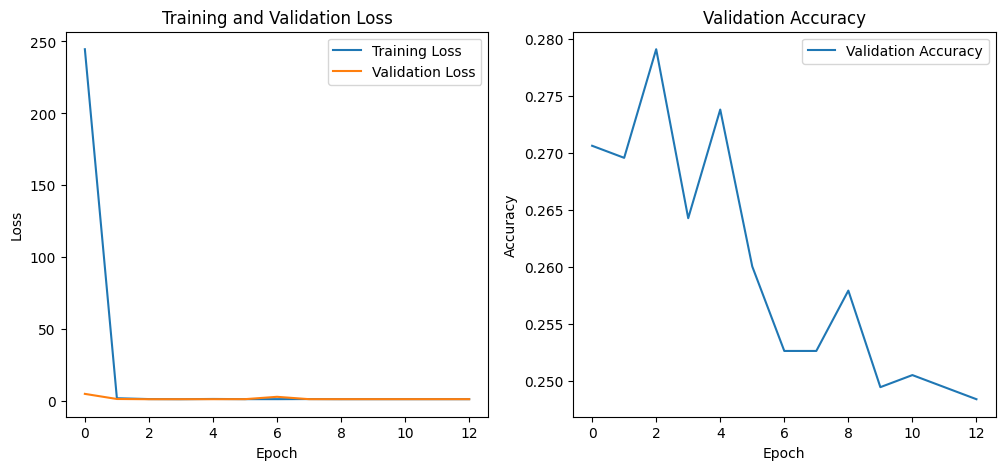

In [19]:
# Plotting training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()